# Carga de datos

In [1]:
!pip install medmnist --quiet
#!pip install --upgrade tensorflow --quiet
!pip install --upgrade keras_tuner --quiet
#!pip install --upgrade keras --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.0 MB/s eta 0:00:00


In [4]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO, Evaluator

import numpy as np
import matplotlib.pyplot as plt
import os; os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import keras; import keras_tuner; from keras import layers
keras.utils.set_random_seed(23)

In [ ]:
data_flag = 'organmnist3d'
download = True

NUM_EPOCHS = 3
BATCH_SIZE = 128
lr = 0.001

info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])

# load the data
train_dataset = DataClass(split='train', download=download)
val_dataset = DataClass(split='val', download=download)
test_dataset = DataClass(split='test', download=download)

# encapsulate data into dataloader form
#train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)

100%|██████████| 32657349/32657349 [00:42<00:00, 763895.28it/s]


Using downloaded and verified file: /root/.medmnist/organmnist3d.npz
Using downloaded and verified file: /root/.medmnist/organmnist3d.npz


In [ ]:
import warnings; warnings.filterwarnings('ignore'); from sklearn.metrics import accuracy_score

In [ ]:
import numpy as np

x, y = train_dataset[:]
x = x[0]
X_train = x.astype(np.float32); y_train = y.astype(np.uint8)

x, y = val_dataset[:]
x = x[0]
X_val = x.astype(np.float32); y_val = y.astype(np.uint8)

x, y = test_dataset[:]
x = x[0]
X_test = x.astype(np.float32); y_test = y.astype(np.uint8)



labels = list(train_dataset.info["label"].values())
num_classes = len(labels)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(971, 28, 28, 28) (971, 1) (610, 28, 28, 28) (610, 1)


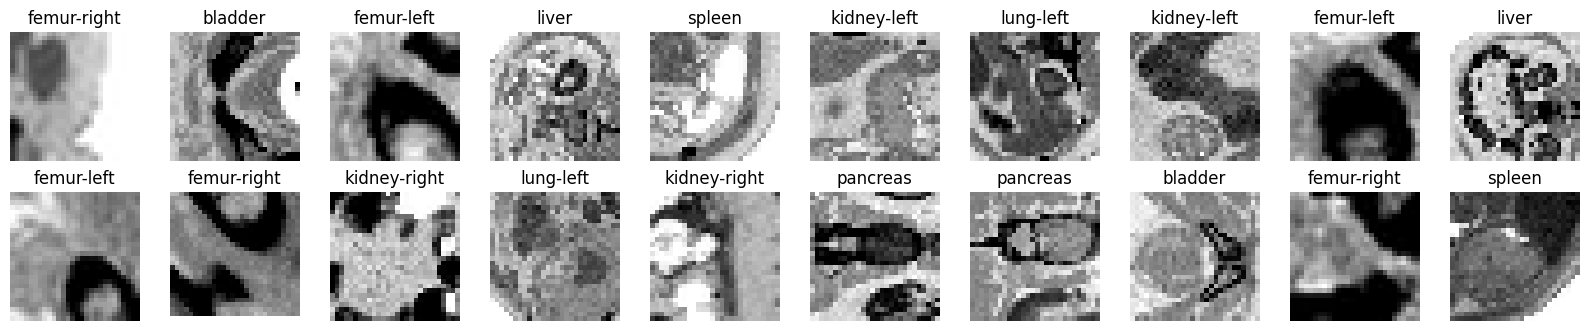

In [ ]:
import matplotlib.pyplot as plt
nrows = 2; ncols = 10
_, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 16*nrows/ncols), constrained_layout=True)
for ax, x, y in zip(axs.flat, X_train, y_train):
  ax.set_axis_off(); image = (x[:,:,0]*255).astype(np.uint8); ax.set_title(labels[y[0]])
  ax.imshow(image, cmap=plt.cm.gray_r, interpolation="none")


In [ ]:
import numpy as np

x, y = train_dataset[:]
x = x[0]
X_train = x.astype(np.float32); y_train = y.astype(np.uint8)

x, y = val_dataset[:]
x = x[0]
X_val = x.astype(np.float32); y_val = y.astype(np.uint8)

x, y = test_dataset[:]
x = x[0]
X_test = x.astype(np.float32); y_test = y.astype(np.uint8)



labels = list(train_dataset.info["label"].values())
num_classes = len(labels)
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(971, 28, 28, 28) (971, 11) (610, 28, 28, 28) (610, 11)


In [ ]:
"""input_dim = 28*28*28

x, y = train_dataset[:]
x = x[0]
X_train = x.astype(np.float32).reshape(x.shape[0], input_dim); y_train = np.squeeze(y.astype(np.uint8))

x, y = val_dataset[:]
x = x[0]
X_val = x.astype(np.float32).reshape(x.shape[0], input_dim); y_val = np.squeeze(y.astype(np.uint8))

x, y = test_dataset[:]
x = x[0]
X_test = x.astype(np.float32).reshape(x.shape[0], input_dim); y_test = np.squeeze(y.astype(np.uint8))

y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

labels = list(train_dataset.info["label"].values())
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)"""

'input_dim = 28*28*28\n\nx, y = train_dataset[:]\nx = x[0]\nX_train = x.astype(np.float32).reshape(x.shape[0], input_dim); y_train = np.squeeze(y.astype(np.uint8))\n\nx, y = val_dataset[:]\nx = x[0]\nX_val = x.astype(np.float32).reshape(x.shape[0], input_dim); y_val = np.squeeze(y.astype(np.uint8))\n\nx, y = test_dataset[:]\nx = x[0]\nX_test = x.astype(np.float32).reshape(x.shape[0], input_dim); y_test = np.squeeze(y.astype(np.uint8))\n\ny_train = keras.utils.to_categorical(y_train, num_classes)\ny_val = keras.utils.to_categorical(y_val, num_classes)\ny_test = keras.utils.to_categorical(y_test, num_classes)\n\nlabels = list(train_dataset.info["label"].values())\nprint(X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape)'

In [12]:
from sklearn.metrics import ConfusionMatrixDisplay
np.set_printoptions(precision=2)
def print_cm(model):
  y_pred = model.predict(X_test).argmax(axis = 1)
  y_true = y_test.argmax(axis = 1)

  disp = ConfusionMatrixDisplay.from_predictions(
          y_true,
          y_pred,
          display_labels=labels,
          cmap=plt.cm.Blues,
          normalize="true",
      )
  disp.ax_.set_title("Confusion Matrix")
  fig = disp.ax_.get_figure()
  fig.set_figwidth(15)
  fig.set_figheight(15)

  disp = ConfusionMatrixDisplay.from_predictions(
          y_true,
          y_pred,
          display_labels=labels,
          cmap=plt.cm.Reds,
          normalize="pred",
      )
  disp.ax_.set_title("Confusion Matrix")
  fig = disp.ax_.get_figure()
  fig.set_figwidth(15)
  fig.set_figheight(15)

In [ ]:
input_shape = X_train[0].shape
input_shape

(28, 28, 28)

# Convolucionales




In [ ]:
class MyHyperModel(keras_tuner.HyperModel):
  def build(self, hp):
    M = keras.Sequential()
    M.add(keras.Input(shape=input_shape))
    filters = hp.Int("filters", min_value=8, max_value=64, step=2, sampling="log")
    M.add(keras.layers.Conv2D(filters, kernel_size=(3, 3), activation="relu"))
    M.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
    M.add(keras.layers.Conv2D(2*filters, kernel_size=(3, 3), activation="relu"))
    M.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
    M.add(keras.layers.Flatten())
    M.add(keras.layers.Dense(units=900, activation='relu'))
    M.add(keras.layers.Dense(num_classes, activation='softmax'))
    opt = keras.optimizers.Adam(learning_rate=0.001619)
    M.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
    return M
  def fit(self, hp, M, x, y, xy_val, **kwargs):
    factor = 0.313359; patience = 10
    reduce_cb = keras.callbacks.ReduceLROnPlateau(
      monitor='val_accuracy', factor=factor, patience=patience, min_delta=1e-4, min_lr=1e-5)
    early_cb = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2*patience, min_delta=1e-5)
    kwargs['callbacks'].extend([reduce_cb, early_cb])
    return M.fit(x, y, batch_size=128, epochs=100, validation_data=xy_val, **kwargs)

In [ ]:
tuner = keras_tuner.BayesianOptimization(
 MyHyperModel(), objective="val_accuracy", max_trials=10, executions_per_trial=1,
 overwrite=True, directory="/tmp", project_name="OrganMNIST3D")

In [ ]:
tuner.search(X_train, y_train, (X_val, y_val))

Trial 10 Complete [00h 00m 19s]
val_accuracy: 0.9751552939414978

Best val_accuracy So Far: 0.9813664555549622
Total elapsed time: 00h 03m 10s


In [ ]:
tuner.results_summary(num_trials=1)


Results summary
Results in /tmp/OrganMNIST3D
Showing 1 best trials
Objective(name="val_accuracy", direction="max")

Trial 07 summary
Hyperparameters:
filters: 64
Score: 0.9813664555549622


In [ ]:
num_models = 4
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=num_models)
best_models = tuner.get_best_models(num_models=num_models)
for m in range(num_models):
 values = best_hyperparameters[m].values
 score = best_models[m].evaluate(X_test, y_test, verbose=0)
 print(f'Model {m}: Hyperparameters: {values!s} Loss: {score[0]:.4} Precisión: {score[1]:.2%}')

Model 0: Hyperparameters: {'filters': 64} Loss: 1.016 Precisión: 79.02%
Model 1: Hyperparameters: {'filters': 64} Loss: 0.7918 Precisión: 77.21%
Model 2: Hyperparameters: {'filters': 64} Loss: 0.7549 Precisión: 78.85%
Model 3: Hyperparameters: {'filters': 64} Loss: 1.021 Precisión: 81.31%


# Aumento de datos

In [ ]:
class MyHyperModel(keras_tuner.HyperModel):
  def build(self, hp):
    M = keras.Sequential()
    M.add(keras.Input(shape=input_shape))
    factor = hp.Float("factor", min_value=0.01, max_value=0.3, step=2, sampling="log")
    M.add(keras.layers.RandomRotation(factor, fill_mode="nearest"))
    M.add(keras.layers.RandomTranslation(factor, factor, fill_mode="nearest"))
    M.add(keras.layers.RandomZoom(factor, fill_mode="nearest"))
    M.add(keras.layers.Rescaling(1./(255/2) -1))
    filters = 64
    M.add(keras.layers.Conv2D(filters, kernel_size=(3, 3), activation="relu"))
    M.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
    M.add(keras.layers.Conv2D(2*filters, kernel_size=(3, 3), activation="relu"))
    M.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
    M.add(keras.layers.Flatten())
    M.add(keras.layers.Dense(units=900, activation='relu'))
    # dropout = hp.Float("dropout", min_value=0.0, max_value=0.5, step=0.1)
    dropout = 0.5
    M.add(keras.layers.Dropout(dropout))
    M.add(keras.layers.Dense(num_classes, activation='softmax'))
    opt = keras.optimizers.Adam(learning_rate=0.001619)
    M.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
    return M
  def fit(self, hp, M, x, y, xy_val, **kwargs):
    factor = 0.313359; patience = 10
    reduce_cb = keras.callbacks.ReduceLROnPlateau(
            monitor='val_accuracy', factor=factor, patience=patience, min_delta=1e-4, min_lr=1e-5)
    early_cb = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2*patience, min_delta=1e-5)
    kwargs['callbacks'].extend([reduce_cb, early_cb])
    return M.fit(x, y, batch_size=128, epochs=100, validation_data=xy_val, **kwargs)

In [ ]:
tuner = keras_tuner.BayesianOptimization(
 MyHyperModel(), objective="val_accuracy", max_trials=10, executions_per_trial=1,
 overwrite=True, directory="/tmp", project_name="OrganMNIST3D")

In [ ]:
tuner.search(X_train, y_train, (X_val, y_val))

Trial 10 Complete [00h 00m 25s]
val_accuracy: 0.95652174949646

Best val_accuracy So Far: 0.9875776171684265
Total elapsed time: 00h 04m 08s


In [ ]:
tuner.results_summary(num_trials=4)

Results summary
Results in /tmp/OrganMNIST3D
Showing 4 best trials
Objective(name="val_accuracy", direction="max")

Trial 04 summary
Hyperparameters:
factor: 0.02
Score: 0.9875776171684265

Trial 07 summary
Hyperparameters:
factor: 0.02
Score: 0.9875776171684265

Trial 00 summary
Hyperparameters:
factor: 0.08
Score: 0.9813664555549622

Trial 01 summary
Hyperparameters:
factor: 0.04
Score: 0.9813664555549622


In [ ]:
num_models = 5
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=num_models)
best_models = tuner.get_best_models(num_models=num_models)
for m in range(num_models):
 values = best_hyperparameters[m].values
 score = best_models[m].evaluate(X_test, y_test, verbose=0)
 print(f'Model {m}: Hyperparameters: {values!s} Loss: {score[0]:.4} Precisión: {score[1]:.2%}')

Model 0: Hyperparameters: {'factor': 0.02} Loss: 0.8474 Precisión: 79.18%
Model 1: Hyperparameters: {'factor': 0.02} Loss: 0.9274 Precisión: 80.98%
Model 2: Hyperparameters: {'factor': 0.08} Loss: 0.7321 Precisión: 81.15%
Model 3: Hyperparameters: {'factor': 0.04} Loss: 0.7491 Precisión: 81.15%
Model 4: Hyperparameters: {'factor': 0.01} Loss: 0.8491 Precisión: 79.84%


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


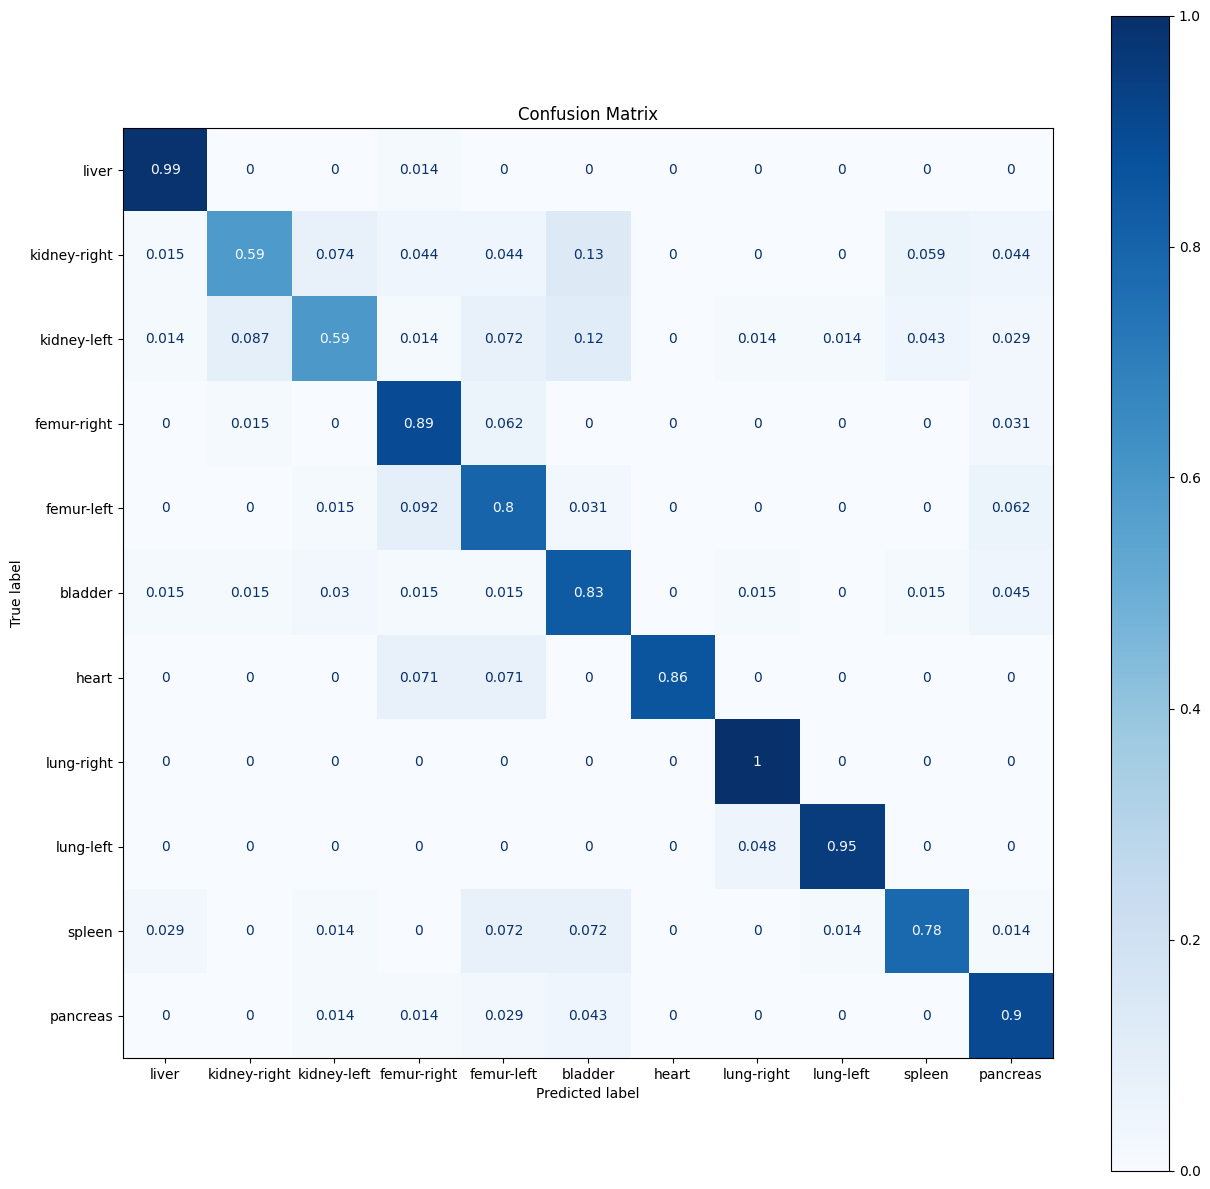

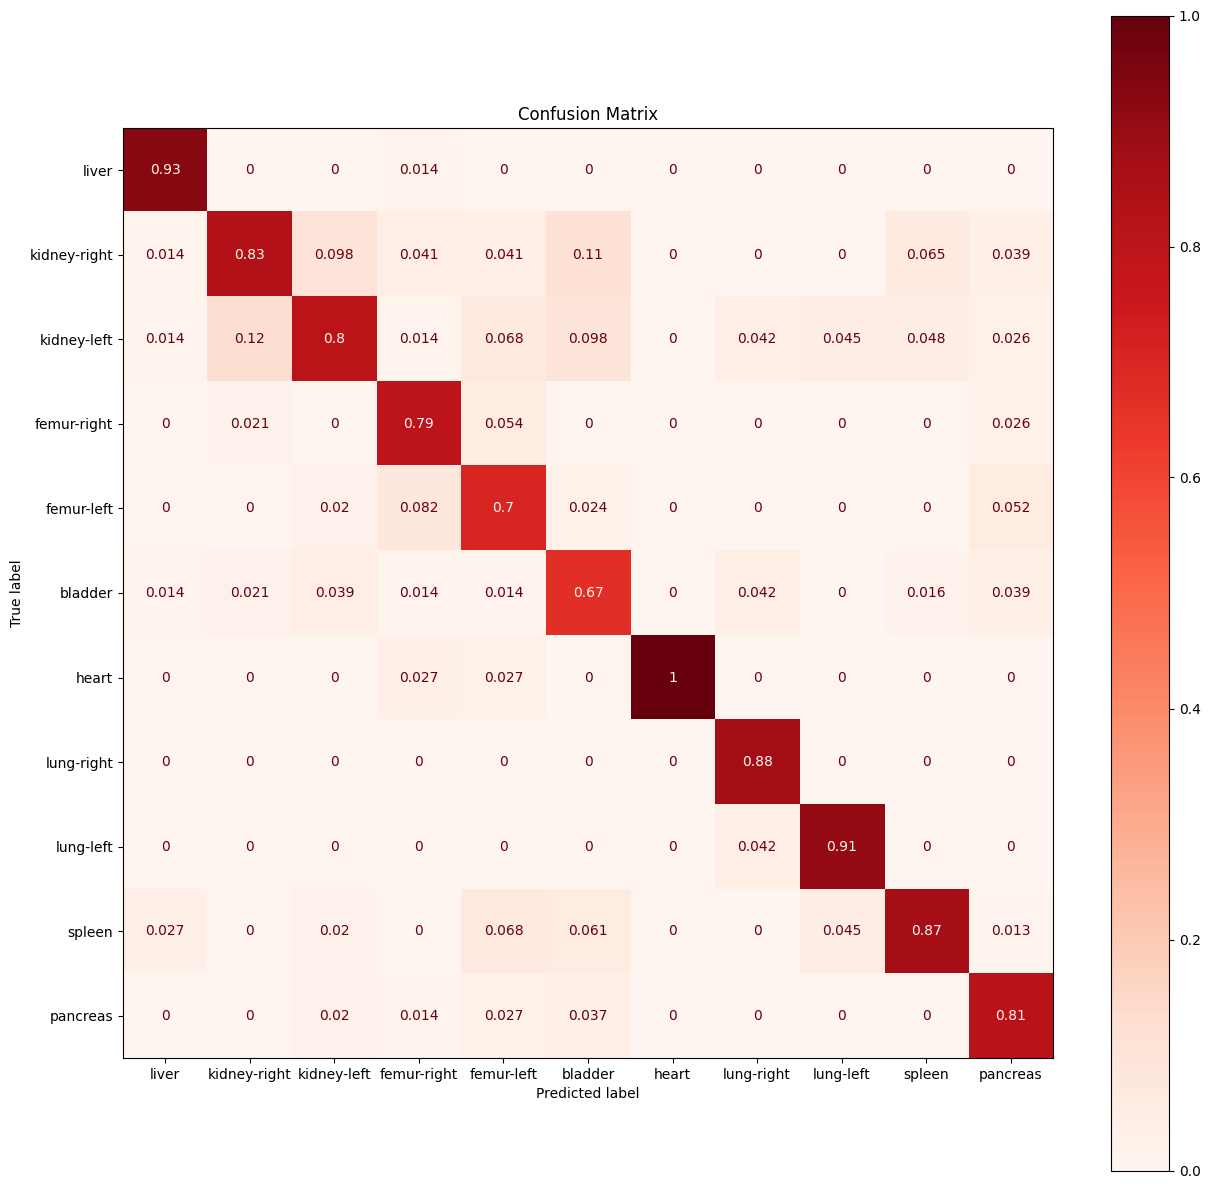

In [ ]:
print_cm(best_models[2])

In [ ]:
from keras import layers
class MyHyperModel(keras_tuner.HyperModel):
  def build(self, hp):
    inputs = keras.Input(shape=input_shape)
    factor = 0.04
    inputs = keras.layers.RandomRotation(factor, fill_mode="nearest")(inputs)
    inputs = keras.layers.RandomTranslation(factor, factor, fill_mode="nearest")(inputs)
    inputs = keras.layers.RandomZoom(factor, fill_mode="nearest")(inputs)
    inputs = keras.layers.Rescaling(1./(255/2) -1)(inputs)
    filters = 64
    conv = layers.Conv2D(filters, kernel_size=(3, 3), activation="relu")(inputs)
    pooling = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    conv = layers.Conv2D(2*filters, kernel_size=(3, 3), activation="relu")(pooling)
    pooling = layers.MaxPooling2D(pool_size=(2, 2))(conv)
    dropout = 0.5
    x = layers.Flatten()(pooling)
    x = layers.Dense(units=900, activation='relu')(x)
    x = layers.Dropout(dropout)(x)
    predictions = layers.Dense(num_classes, activation='softmax')(x)
    M = keras.models.Model(inputs=inputs, outputs=predictions)
    learning_rate = hp.Float("learning rate", min_value=0.001, max_value=0.002)
    opt = keras.optimizers.Adam(learning_rate=learning_rate)
    M.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
    return M
  def fit(self, hp, M, x, y, xy_val, **kwargs):
    factor = 0.313359; patience = 10
    reduce_cb = keras.callbacks.ReduceLROnPlateau(
      monitor='val_accuracy', factor=factor, patience=patience, min_delta=0.0, min_lr=0.0)
    early_cb = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2*patience, min_delta=0)
    kwargs['callbacks'].extend([reduce_cb, early_cb])
    return M.fit(x, y, batch_size=128, epochs=100, validation_data=xy_val, **kwargs)

In [ ]:
tuner = keras_tuner.BayesianOptimization(
 MyHyperModel(), objective="val_accuracy", max_trials=10, executions_per_trial=1,
 overwrite=True, directory="/tmp", project_name="OrganMNIST3D")

In [ ]:
tuner.search(X_train, y_train, (X_val, y_val))

Trial 10 Complete [00h 00m 23s]
val_accuracy: 0.9751552939414978

Best val_accuracy So Far: 0.9937888383865356
Total elapsed time: 00h 03m 37s


In [ ]:
tuner.results_summary(num_trials=3)

Results summary
Results in /tmp/OrganMNIST3D
Showing 3 best trials
Objective(name="val_accuracy", direction="max")

Trial 01 summary
Hyperparameters:
learning rate: 0.0017453712418480484
Score: 0.9937888383865356

Trial 06 summary
Hyperparameters:
learning rate: 0.0011845497886081586
Score: 0.9875776171684265

Trial 07 summary
Hyperparameters:
learning rate: 0.0017476248138204972
Score: 0.9875776171684265


In [ ]:
num_models = 10
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=num_models)
best_models = tuner.get_best_models(num_models=num_models)
for m in range(num_models):
 values = best_hyperparameters[m].values
 score = best_models[m].evaluate(X_test, y_test, verbose=0)
 print(f'Model {m}: Hyperparameters: {values!s} Loss: {score[0]:.4} Precisión: {score[1]:.2%}')

Model 0: Hyperparameters: {'learning rate': 0.0017453712418480484} Loss: 0.807 Precisión: 81.97%
Model 1: Hyperparameters: {'learning rate': 0.0011845497886081586} Loss: 0.6761 Precisión: 80.33%
Model 2: Hyperparameters: {'learning rate': 0.0017476248138204972} Loss: 0.7588 Precisión: 77.05%
Model 3: Hyperparameters: {'learning rate': 0.001409745205082559} Loss: 0.783 Precisión: 80.98%
Model 4: Hyperparameters: {'learning rate': 0.001330384000391946} Loss: 0.8341 Precisión: 80.49%
Model 5: Hyperparameters: {'learning rate': 0.001667710963998952} Loss: 0.9348 Precisión: 79.34%
Model 6: Hyperparameters: {'learning rate': 0.0011807180628585403} Loss: 0.8369 Precisión: 78.03%
Model 7: Hyperparameters: {'learning rate': 0.0019567189532337316} Loss: 0.8595 Precisión: 79.51%
Model 8: Hyperparameters: {'learning rate': 0.0016645212774598515} Loss: 0.7672 Precisión: 77.54%
Model 9: Hyperparameters: {'learning rate': 0.0016744080150747737} Loss: 0.9334 Precisión: 79.51%


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step


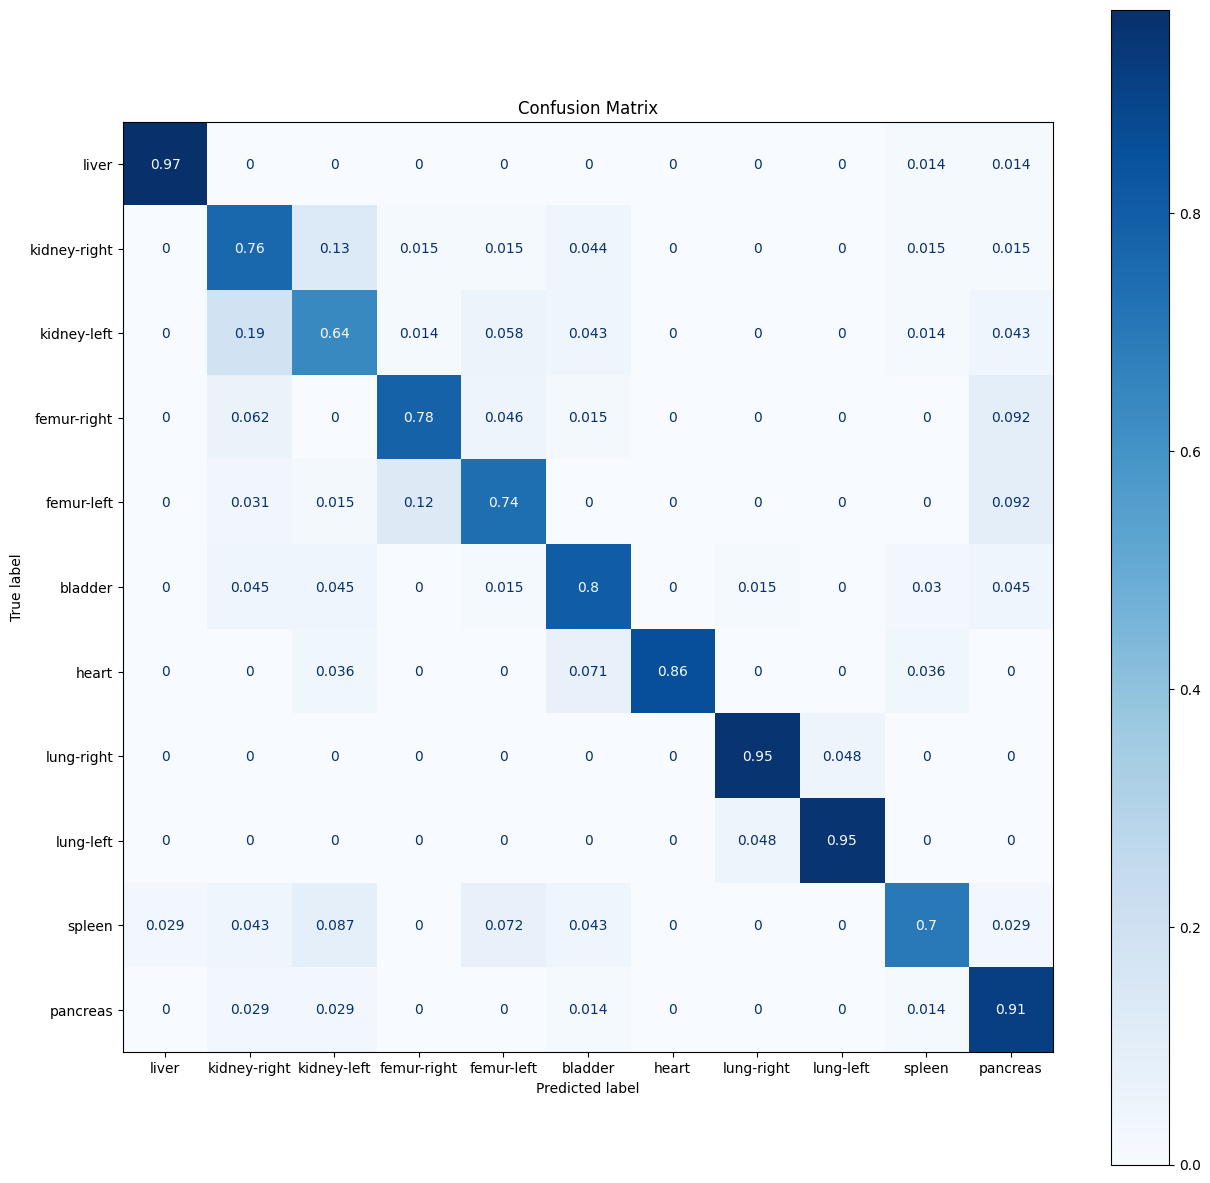

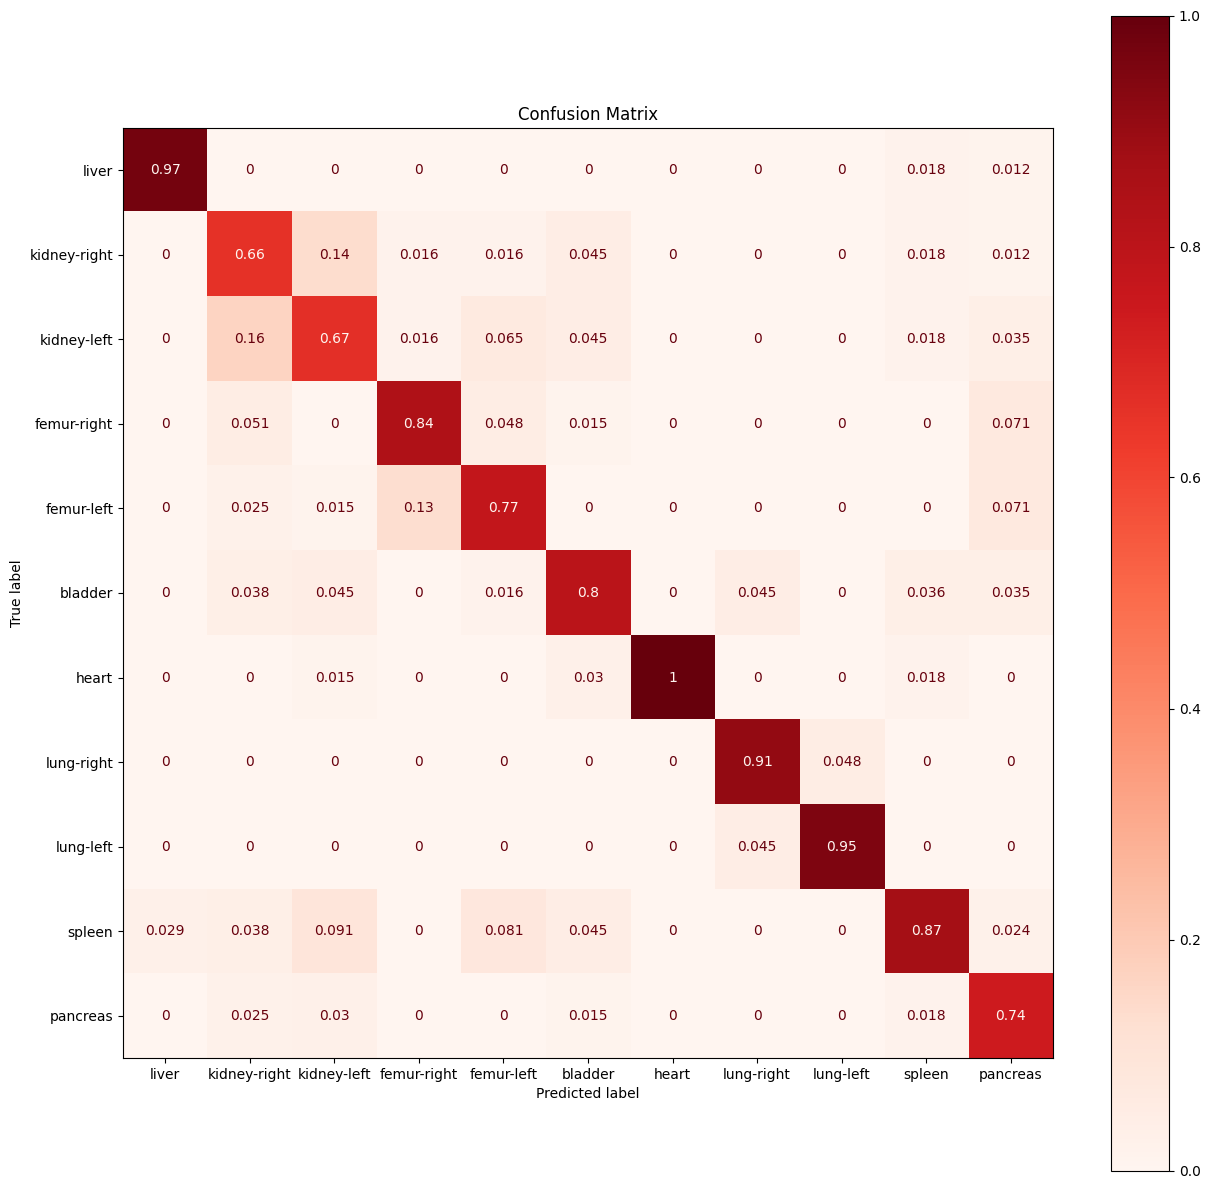

In [ ]:
print_cm(best_models[1])

# Fine-Tuning

In [ ]:
import numpy as np; import matplotlib.pyplot as plt; import os; os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import keras; from keras.applications.resnet_v2 import ResNet50V2
from keras import layers

M = keras.applications.resnet_v2.ResNet50V2(include_top=False)

In [ ]:
model_config = M.get_config()

In [ ]:
model_config["layers"][0]["config"]["batch_shape"] = (None, None, None, 28)

In [ ]:
model_config["layers"][1]["inbound_nodes"][0]["args"][0]["config"]["shape"] = (None, None, None, 28)
model_config["layers"][1]["build_config"]["input_shape"] = (None, None, None, 28)

In [ ]:
model_config['input_layers']

[['input_layer_38', 0, 0]]

In [ ]:
model_config["layers"][2]["inbound_nodes"][0]["args"][0]["config"]["shape"] = (None, None, None, 28)
model_config["layers"][2]["build_config"]["input_shape"] = (None, None, None, 28)

In [ ]:
new_model = M.__class__.from_config(model_config, custom_objects={})  # change custom objects if necessary

In [ ]:
new_model.trainable = True
for layer in new_model.layers:
  if not isinstance(layer, layers.BatchNormalization):
    layer.trainable = True
inputs = keras.Input(shape=input_shape)
factor = 0.04
x = keras.layers.RandomRotation(factor, fill_mode="nearest")(inputs)
x = keras.layers.RandomTranslation(factor, factor, fill_mode="nearest")(x)
x = keras.layers.RandomZoom(factor, fill_mode="nearest")(x)
x = layers.Rescaling(scale=1 / 127.5, offset=-1)(x)
x = new_model(x, training=False)
x = layers.Flatten()(x[0])
x = layers.Dense(units=900, activation='relu')(x)
x = layers.Dropout(0.5)(x)
predictions = layers.Dense(num_classes, activation='softmax')(x)
M = keras.models.Model(inputs=inputs, outputs=predictions)
opt = keras.optimizers.Adam(learning_rate=0.0017)
M.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

In [ ]:
M.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_40 (InputLayer)          │ (None, 28, 28, 28)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_14 (Rescaling)             │ (None, 28, 28, 28)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50v2 (Functional)              │ (None, 1, 1, 2048)          │      23,643,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 900)                 │       1,844,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 900)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 11)                  │           9,911 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25,497,211 (97.26 MB)

 Trainable params: 25,451,771 (97.09 MB)

 Non-trainable params: 45,440 (177.50 KB)

In [ ]:
filename = 'ResNet_fine-tuning.keras'
checkpoint_cb = keras.callbacks.ModelCheckpoint(
 filepath=filename, monitor='val_accuracy', save_best_only=True, verbose=1)
reduce_cb = keras.callbacks.ReduceLROnPlateau(
 monitor='val_accuracy', factor=0.3, patience=15, min_delta=0.0005, min_lr=0.0)
early_cb = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=25, min_delta=0.0005)
H = M.fit(X_train, y_train, batch_size=32, epochs=25, validation_data=(X_val, y_val), verbose=1,
 callbacks=[checkpoint_cb, early_cb, reduce_cb])

Epoch 1/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.4225 - loss: 2.2554
Epoch 1: val_accuracy improved from -inf to 0.08696, saving model to ResNet_fine-tuning.keras
31/31 ━━━━━━━━━━━━━━━━━━━━ 56s 398ms/step - accuracy: 0.4248 - loss: 2.2488 - val_accuracy: 0.0870 - val_loss: 72606.3750 - learning_rate: 0.0017
Epoch 2/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.5733 - loss: 1.5987
Epoch 2: val_accuracy did not improve from 0.08696
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 81ms/step - accuracy: 0.5739 - loss: 1.5942 - val_accuracy: 0.0870 - val_loss: 20797.9727 - learning_rate: 0.0017
Epoch 3/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.6392 - loss: 1.2259
Epoch 3: val_accuracy did not improve from 0.08696
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - accuracy: 0.6390 - loss: 1.2275 - val_accuracy: 0.0870 - val_loss: 128166.6328 - learning_rate: 0.0017
Epoch 4/25
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.5870 - loss: 1.6253
Epoch 4: val_accuracy did n

In [ ]:
print_cm(M)

In [5]:
data_flag = 'organmnist3d'
download = True

NUM_EPOCHS = 3
BATCH_SIZE = 128
lr = 0.001

info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])

# load the data
train_dataset = DataClass(split='train', download=download, size = 64)
val_dataset = DataClass(split='val', download=download, size = 64)
test_dataset = DataClass(split='test', download=download, size = 64)

100%|██████████| 361470105/361470105 [08:44<00:00, 688708.75it/s]


Using downloaded and verified file: /root/.medmnist/organmnist3d_64.npz
Using downloaded and verified file: /root/.medmnist/organmnist3d_64.npz


In [6]:
import numpy as np

x, y = train_dataset[:]
x = x[0]
X_train = x.astype(np.float32); y_train = y.astype(np.uint8)

x, y = val_dataset[:]
x = x[0]
X_val = x.astype(np.float32); y_val = y.astype(np.uint8)

x, y = test_dataset[:]
x = x[0]
X_test = x.astype(np.float32); y_test = y.astype(np.uint8)



labels = list(train_dataset.info["label"].values())
num_classes = len(labels)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(971, 64, 64, 64) (971, 1) (610, 64, 64, 64) (610, 1)


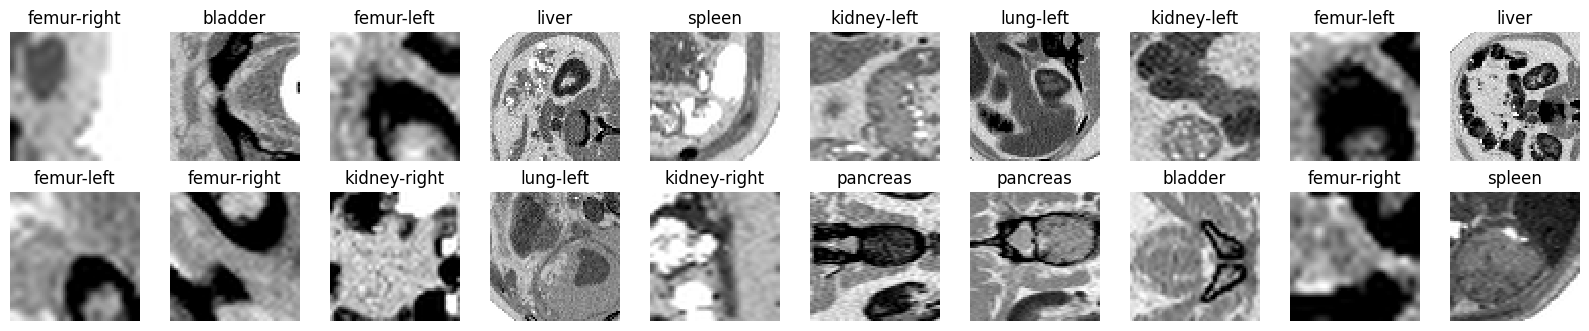

In [7]:
import matplotlib.pyplot as plt
nrows = 2; ncols = 10
_, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 16*nrows/ncols), constrained_layout=True)
for ax, x, y in zip(axs.flat, X_train, y_train):
  ax.set_axis_off(); image = (x[:,:,0]*255).astype(np.uint8); ax.set_title(labels[y[0]])
  ax.imshow(image, cmap=plt.cm.gray_r, interpolation="none")

In [8]:
import numpy as np

x, y = train_dataset[:]
x = x[0]
X_train = x.astype(np.float32); y_train = y.astype(np.uint8)

x, y = val_dataset[:]
x = x[0]
X_val = x.astype(np.float32); y_val = y.astype(np.uint8)

x, y = test_dataset[:]
x = x[0]
X_test = x.astype(np.float32); y_test = y.astype(np.uint8)



labels = list(train_dataset.info["label"].values())
num_classes = len(labels)
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(971, 64, 64, 64) (971, 11) (610, 64, 64, 64) (610, 11)


In [9]:
input_shape = X_train[0].shape
input_shape

(64, 64, 64)

In [10]:
M = keras.applications.resnet_v2.ResNet50V2(include_top=False)
M.trainable = True
for layer in M.layers:
  if not isinstance(layer, layers.BatchNormalization):
    layer.trainable = True
inputs = keras.Input(shape=input_shape)
x = inputs[:,:,:,:3]
x = layers.Rescaling(scale=1 / 127.5, offset=-1)(x)
x = layers.Resizing(224, 224, interpolation="nearest")(x)
x = M(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Flatten()(x)
x = layers.Dense(units=900, activation='relu')(x)
x = layers.Dropout(0.5)(x)
predictions = layers.Dense(num_classes, activation='softmax')(x)
M = keras.models.Model(inputs=inputs, outputs=predictions)
opt = keras.optimizers.Adam(learning_rate=0.001)
M.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
filename = 'ResNet_fine-tuning.keras'
checkpoint_cb = keras.callbacks.ModelCheckpoint(
 filepath=filename, monitor='val_accuracy', save_best_only=True, verbose=1)
reduce_cb = keras.callbacks.ReduceLROnPlateau(
 monitor='val_accuracy', factor=0.3, patience=5, min_delta=0.0005, min_lr=0.0)
early_cb = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, min_delta=0.0005)
H = M.fit(X_train, y_train, batch_size=32, epochs=5, validation_data=(X_val, y_val), verbose=1,
 callbacks=[checkpoint_cb, early_cb, reduce_cb])


94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.2681 - loss: 2.1645   
Epoch 1: val_accuracy improved from -inf to 0.09938, saving model to ResNet_fine-tuning.keras
31/31 ━━━━━━━━━━━━━━━━━━━━ 111s 2s/step - accuracy: 0.2706 - loss: 2.1553 - val_accuracy: 0.0994 - val_loss: 160.4345 - learning_rate: 0.0010
Epoch 2/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.5422 - loss: 1.3345
Epoch 2: val_accuracy did not improve from 0.09938
31/31 ━━━━━━━━━━━━━━━━━━━━ 66s 239ms/step - accuracy: 0.5433 - loss: 1.3320 - val_accuracy: 0.0870 - val_loss: 51.4537 - learning_rate: 0.0010
Epoch 3/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.6052 - loss: 1.1752
Epoch 3: val_accuracy did not improve from 0.09938
31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 243ms/step - accuracy: 0.6062 - loss: 1.1737 - val_accuracy: 0.0807 - val_loss: 20.2902 - learning_rate: 0.0010
Epoch 4/5
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.7120 

20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 332ms/step


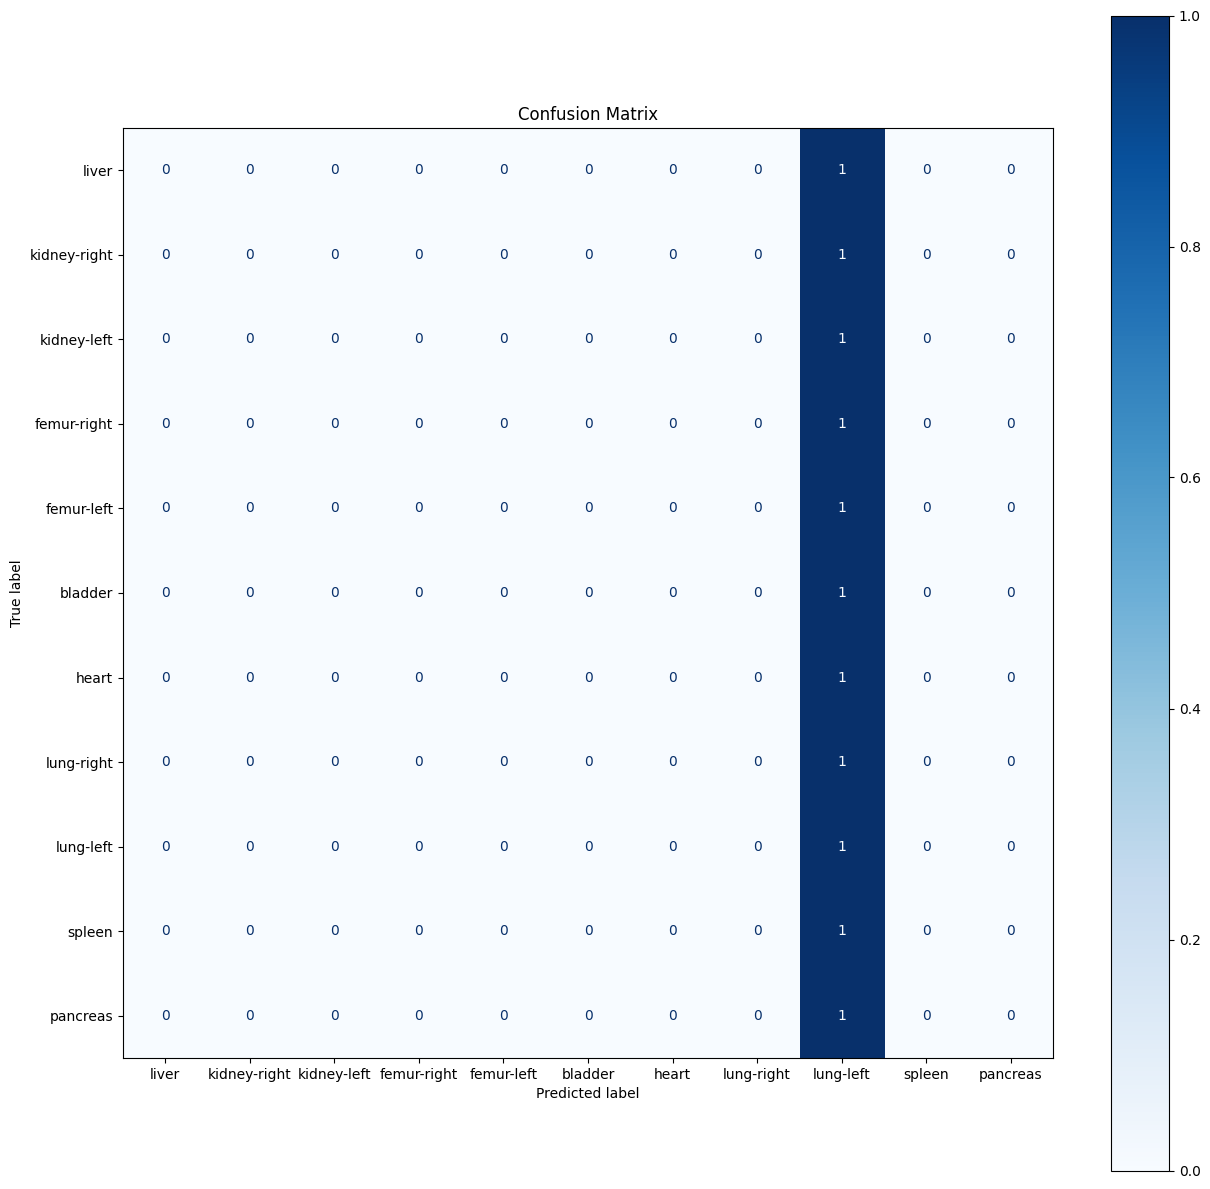

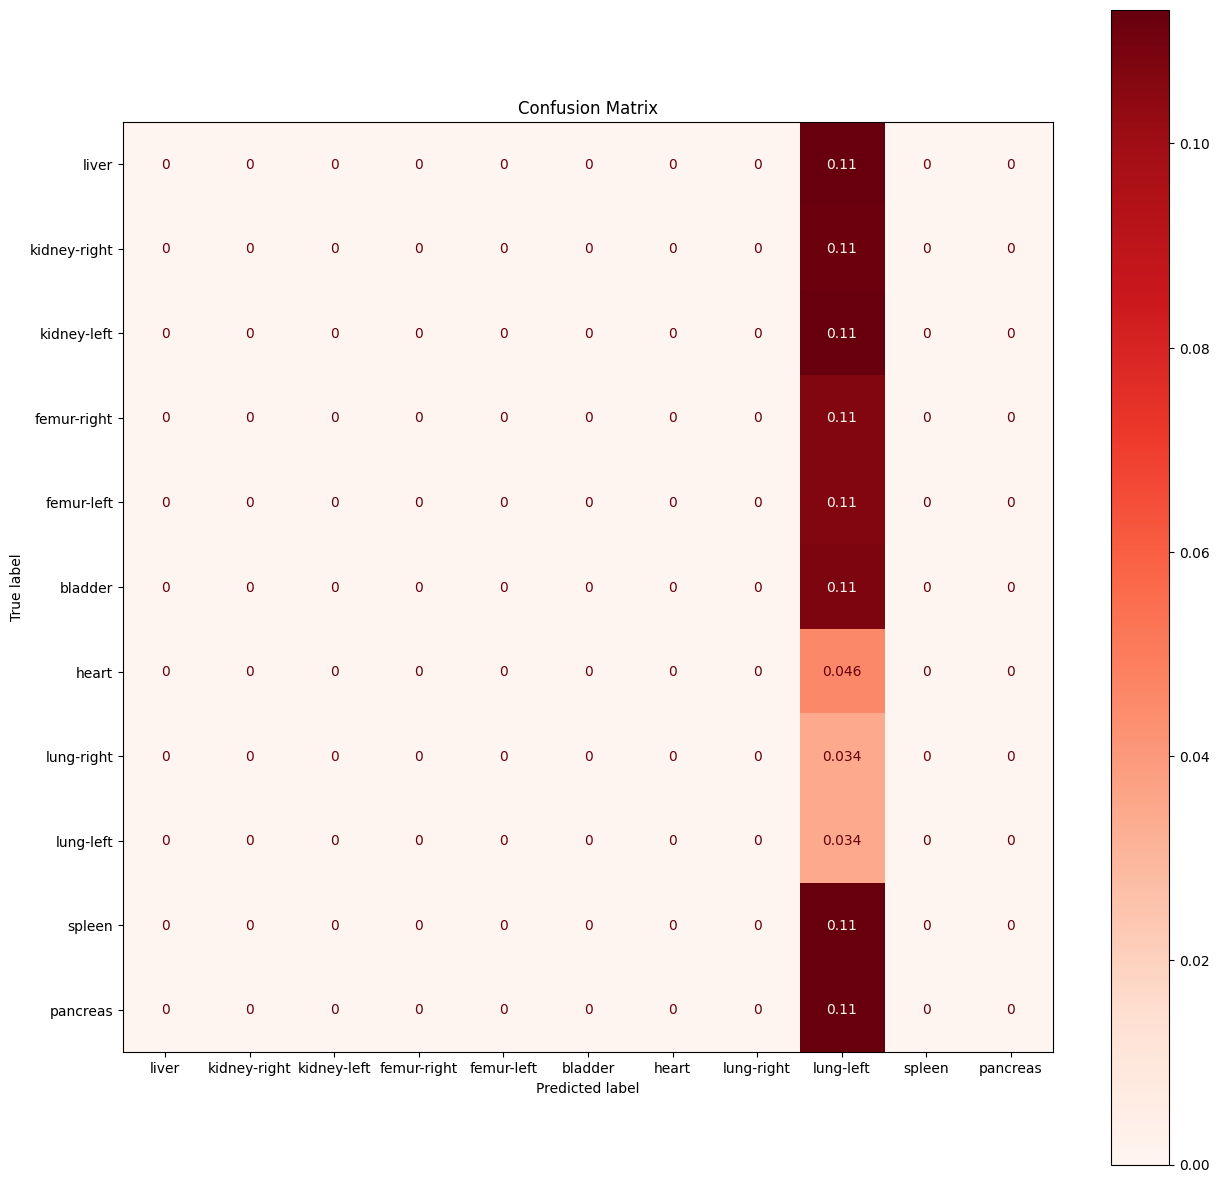

In [13]:
print_cm(M)